In [ ]:
#!pip install -U torch torchvision

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
#import PIL

# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [1]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 24 17:33:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image


from torchvision import transforms, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn
from torchvision import datasets, models, transforms

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
from pathlib import Path
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

In [4]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [6]:
import pandas as pd

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_val_files]

data = pd.Series(train_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


In [7]:
def imgnet_transform():
          
    list_transformation = transforms.RandomOrder([
              transforms.Compose([
              transforms.Resize(size=320, max_size=321),
              transforms.CenterCrop(size=320),
              transforms.RandomCrop(270)
                                ]),
              transforms.RandomRotation(45),
            
              
                                                    ])
    transform_list = transforms.Compose([
               list_transformation,
               transforms.Resize(size=(224, 224)),
               transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
               transforms.ToTensor(),
               transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225]) ,
                                              ])
  
    return transform_list 

full_data = datasets.ImageFolder(root=TRAIN_DIR, transform=imgnet_transform())

In [8]:
targets = pd.DataFrame(full_data.targets)
class_counts = targets.value_counts()
sample_weights =[1/class_counts[i] for i in targets.values.T[0]]

In [9]:
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
train_loader = DataLoader(full_data, batch_size=16, sampler = sampler)

In [10]:
pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6539121a0b04600ab256866fb86c7dd74055a6676ceb5291a195e8c34266a8b7
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


In [11]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b7'
model = EfficientNet.from_pretrained(model_name) 
for param in model.parameters():
    param.require_grad = False
    
model._fc = nn.Linear(2560, 42)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [14]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import torch.nn.functional as F
from tqdm.autonotebook import tqdm, trange

# Заменяем Fully-Connected слой на наш линейный классификатор


# Использовать ли GPU
model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.AdamW(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
max_epochs = 10
accuracy = []
for epoch in range(max_epochs):
    
    epoch_correct = 0
    epoch_all = 0
    for x_batch, y_batch in tqdm(train_loader):
        
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        model.train()
        optimizer_ft.zero_grad()
          
        outp = model(x_batch)  
          
        preds = outp.argmax(-1)
        correct = (preds.flatten() == y_batch).type(torch.float32).sum() 
        all = len(preds) 
        epoch_correct += correct.item()
        epoch_all += all
         
        loss = loss_fn(outp, y_batch)
        loss.backward()
        optimizer_ft.step()
              
       
        
        
    exp_lr_scheduler.step()
    print(f"Epoch: {epoch+1}")
    print(f"Accuracy: {epoch_correct/epoch_all}")
    accuracy.append(epoch_correct/epoch_all)

  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 1
Accuracy: 0.8440739502221373


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 2
Accuracy: 0.976783069794105


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 3
Accuracy: 0.9831844456121913


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 4
Accuracy: 0.9867673052118664


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 5
Accuracy: 0.9889647924330005


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 6
Accuracy: 0.9903979362728705


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 7
Accuracy: 0.9903501648115416


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 8
Accuracy: 0.9940763387952037


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 9
Accuracy: 0.9957961114030478


  0%|          | 0/1309 [00:00<?, ?it/s]

Epoch: 10
Accuracy: 0.9966559977069699


In [16]:
DATA_MODES = ['train', 'val', 'test']

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [17]:
test_dataset = SimpsonsDataset(test_files, mode="test")

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.cuda()
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(model, test_loader)


preds = [full_data.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [20]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [21]:
my_submit.to_csv('data.csv', index=False)

Последняя версия data(3)

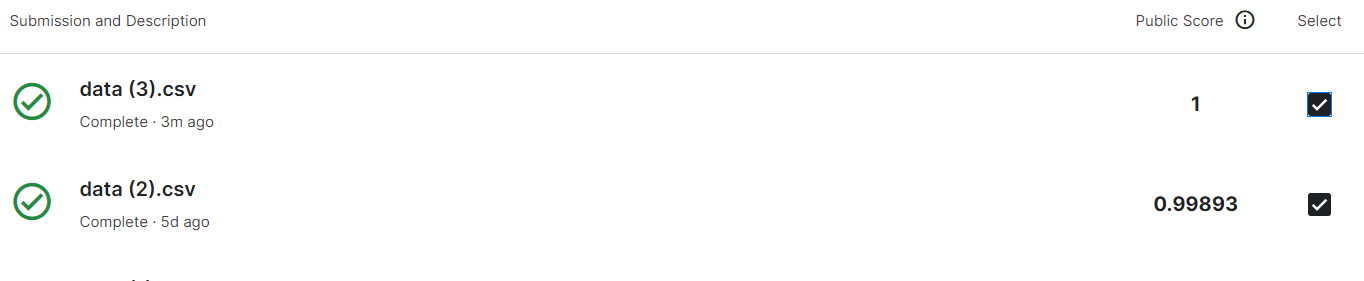


In [22]:
import os
os.chdir(r'../working')
from IPython.display import FileLink
FileLink(r'data.csv')

/kaggle/working/data.csv